# moosic project (module 60)

## Business Questions
- Are Spotify’s audio features able to identify “similar songs”, as defined by humanly detectable criteria? When you listen to two rock ballads, two operas or two drum & bass songs, you identify them as similar songs. Are these similarities detectable using the audio features from Spotify?
- Is K-Means a good method to create playlists? Would you stick with this algorithm moving forward, or explore other methods to create playlists?

By the end of this project, you are expected to present your clusters to the team and discuss these questions with them.

**Remember**
- 50 to 250 songs per playlist 
- => 20 to 100 clusters

## work guidelines

- Clean and comment your code. Discard unused code and describe the process on markdown cells.
- Structure properly your directory, with the proper folders and no “Untitled.ipynb” files floating around.
- When possible, create functions and import them into your notebooks.
- Unit-test your scripts and notebooks by making sure they are bug-free when you run them from scratch.

## workflow
    Data preparation:
        Reading the data
        Initial quick exploration
        Dropping unwanted features
        
    Modelling:
        Data scaling (potentially, other transformations)
        K-Means exploration of clusters (elbow method, silhouette coefficient…)
        K-Means final model
        
    Cluster exploration:
        Univariate , bivariate, and multivariate exploration of the clusters
        Manual labelling of the clusters

## Understanding Audio Features
- **acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
- **danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
- **duration_ms**: The duration of the track in milliseconds.
- **energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
- **instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
- **key**: The key the track is in. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.
- **liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
- **loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.
- **mode**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
- **speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
- **tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
- **time_signature**: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).
- **valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

# Imports and Settings

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import plotly.graph_objects as go # solar radar plot for multidimensional graph

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn import set_config

# settings
set_config(transform_output="pandas")
# Change pandas display for readbility
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent wrapping
# pd.set_option('display.float_format', lambda x: '%.2f' % x)  #shortens to two decimals after the dot
# pd.set_option('display.max_rows', 1000)
# pd.set_option("display.max_colwidth", 100)
# >>> https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html

In [2]:
# basic settings ----------------------> INPUT <---------------------
seed = 666

In [3]:
# import data
data = pd.read_table("data/df_audio_features_5000.csv", sep=",")
data = data.sample(n=500, random_state=seed)

In [4]:
# # import data from google drive (working with collab)
# url = "https://drive.google.com/file/d/1wT7KMZwcFKe49Qs4qGC6LdsN2WRp80bh/view?usp=drive_link"
# path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
# data = pd.read_csv(path)

# Preprocessing

## Exploring Data

In [5]:
data.describe()

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,5.000000e+02,500.000000
mean,2601.162000,0.511671,0.635803,5.190000,-9.472606,0.658000,0.078730,0.321607,0.246071,0.177336,0.44855,119.276770,2.484170e+05,3.886000
std,1558.543384,0.213583,0.293013,3.573716,6.529942,0.474855,0.068185,0.362341,0.367807,0.140012,0.27725,30.479785,1.082802e+05,0.453227
min,2.000000,0.059600,0.000930,0.000000,-42.959000,0.000000,0.023200,0.000000,0.000000,0.034000,0.02280,58.686000,5.838700e+04,1.000000
25%,1292.750000,0.309750,0.430000,2.000000,-11.446250,0.000000,0.038850,0.006638,0.000000,0.091500,0.21100,96.024000,1.933935e+05,4.000000
50%,2598.500000,0.553500,0.731500,5.000000,-6.980000,1.000000,0.051950,0.143500,0.000801,0.122000,0.42550,119.823000,2.232130e+05,4.000000
75%,3938.250000,0.688250,0.878000,8.000000,-5.294750,1.000000,0.087775,0.658000,0.532000,0.219000,0.68725,135.767250,2.672730e+05,4.000000
max,5234.000000,0.953000,0.997000,11.000000,-0.758000,1.000000,0.467000,0.996000,0.969000,0.981000,0.97700,205.846000,1.050440e+06,5.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 225 to 3464
Data columns (total 19 columns):
 #   Column                                                                                                                                                                             Non-Null Count  Dtype  
---  ------                                                                                                                                                                             --------------  -----  
 0   Unnamed: 0                                                                                                                                                                         500 non-null    int64  
 1   name                                                                                                                                                                               500 non-null    object 
 2   artist                                                      

In [7]:
data.columns

Index(['Unnamed: 0',
       'name                                                                                                                                                                             ',
       'artist                                          ', 'danceability ',
       'energy   ', 'key ', 'loudness ', 'mode ', 'speechiness ',
       'acousticness ', 'instrumentalness ', 'liveness ', 'valence ',
       'tempo   ', 'type ', 'duration_ms ', 'time_signature ',
       'id                     ', 'html'],
      dtype='object')

## Cleaning

In [8]:
data.columns = data.columns.str.strip()

In [9]:
data.drop_duplicates(subset=['id'], inplace=True)

In [10]:
data.columns

Index(['Unnamed: 0', 'name', 'artist', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'duration_ms', 'time_signature',
       'id', 'html'],
      dtype='object')

In [11]:
data_df = data.drop(["Unnamed: 0", "name", "artist", "type", "id", "html"], axis=1)
drops = data.drop(["danceability", "energy", "key",
       "loudness", "mode", "speechiness", "acousticness", "instrumentalness",
       "liveness", "valence", "tempo", "type", "duration_ms", "time_signature"], axis=1)

## Scaling

In [12]:
def scale(data_df):

    df = data_df
    methods = ["minmax", "standard", "robust", "quantile", "power"]
    scaling_methods = [MinMaxScaler(feature_range=(0, 1)), StandardScaler(), RobustScaler(), QuantileTransformer(n_quantiles=df.shape[0], output_distribution='uniform'), PowerTransformer()]
    scaled_dfs_dict = {}

    # Scaling
    for m, s in zip(methods, scaling_methods):
        scaled_dfs_dict[m + "_scaled_df"] = pd.DataFrame(s.fit_transform(df), index=df.index, columns=df.columns)

    return scaled_dfs_dict

### Heatmap for various scaling methods

In [13]:
def euclidize(scaled_dfs_dict):

    df = data_df
    methods = ["minmax", "standard", "robust", "quantile", "power"]
    euclidean_arrays = {}

    # Euclidean Distances
    for m in methods:
        distances_array = pairwise_distances(scaled_dfs_dict[m + "_scaled_df"], metric='euclidean')
        euclidean_arrays["Euclidean_"+m+"_array"] = pd.DataFrame(distances_array, index=df.index, columns=df.index,)

    return euclidean_arrays

In [14]:
def heatmap(euclidean_arrays):

    methods = ["minmax", "standard", "robust", "quantile", "power"]
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 12))
    axes = {"ax1": ax1, "ax2": ax2, "ax3": ax3, "ax4": ax4, "ax5": ax5, "ax6": ax6}

    # Heatmaps
    for m, a in zip(methods, axes.values()):
        sns.heatmap(euclidean_arrays["Euclidean_"+m+"_array"], ax=a, linewidths=.001, cmap="Spectral")
        a.set_title(m + "_scaled")
        a.set_xticks([])
        a.set_yticks([])
    plt.show()

    return

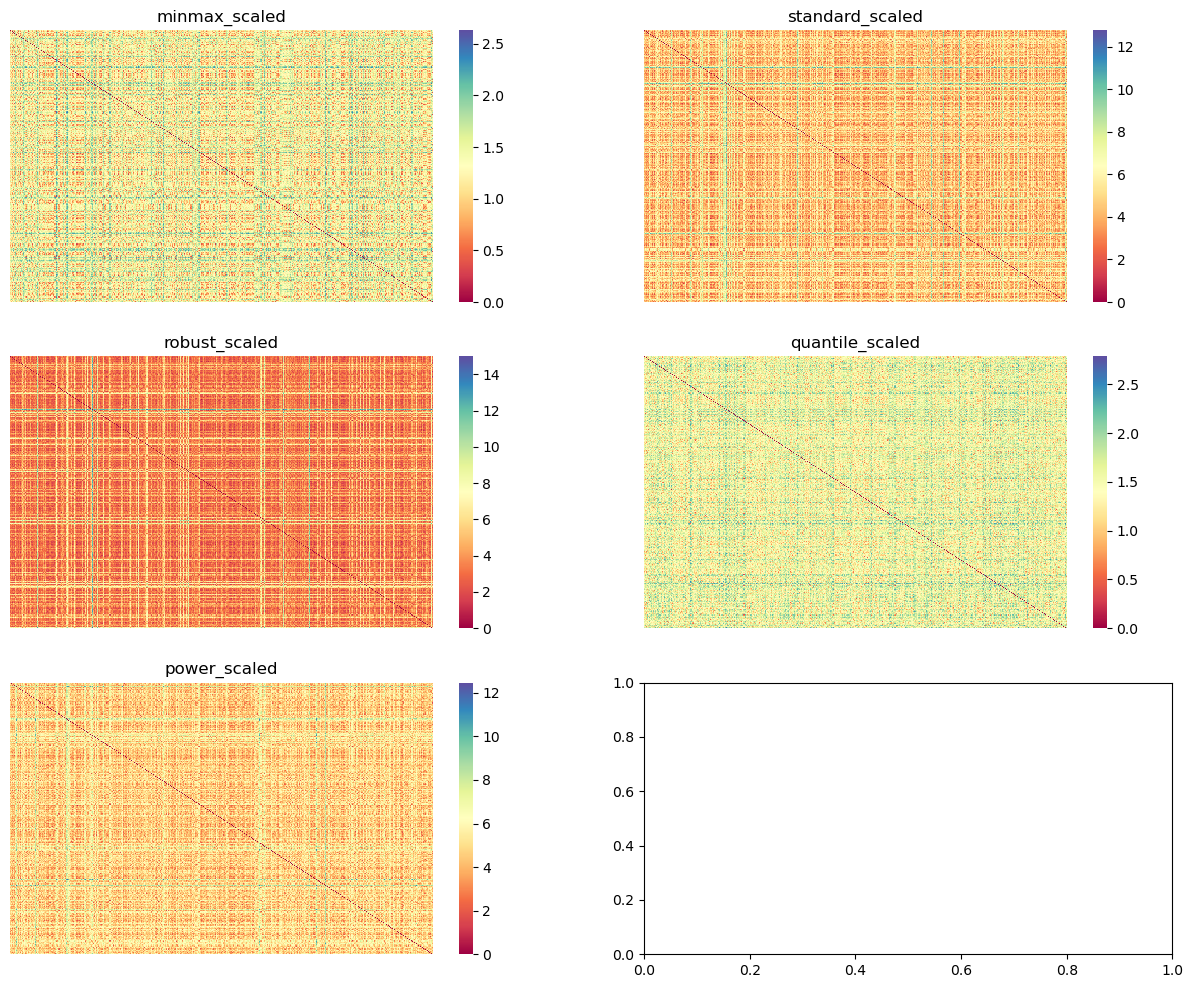

In [15]:
# calling functions

scaled_dfs_dict = scale(data_df)
euclidean_arrays = euclidize(scaled_dfs_dict)
heatmap(euclidean_arrays)

## PCA

In [16]:
# basic settings ----------------------> INPUT <---------------------
the_k = 76   #51 84
m = "standard"   #["minmax", "standard", "robust", "quantile", "power"]
pca_percentage = 0.90
df = data_df

In [17]:
# take data from after cleaning
data_df = data_df

# call scaling function
scaled_dfs_dict = scale(data_df)

# prep output: data slice from dict
scaled_df = scaled_dfs_dict[m + "_scaled_df"]

In [18]:
# Prep: Initialise a model
my_kmeans = KMeans(n_clusters= the_k, # you always choose the number of k here
                   n_init="auto",
                   random_state = seed)

# Fit the model to the data
my_kmeans.fit(df)

# Obtain the cluster output
clusters = my_kmeans.labels_

# Attach the cluster output to a new DataFrame
clusters_df = pd.DataFrame(index=df.index,
                           data={"base_cluster": clusters})

clusters_df.sort_values(by="base_cluster")

,base_cluster
2557,0
2444,0
2624,0
1136,0
4483,1
...,...
4829,74
5232,74
5153,75
4008,75


### find the elbow (.explained_variance_ratio_)

In [19]:
# setting up basics
df = scaled_df

pca = PCA()
pca.fit(df)
pca_basic_df = pca.transform(df)

C:\Users\Administrator\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


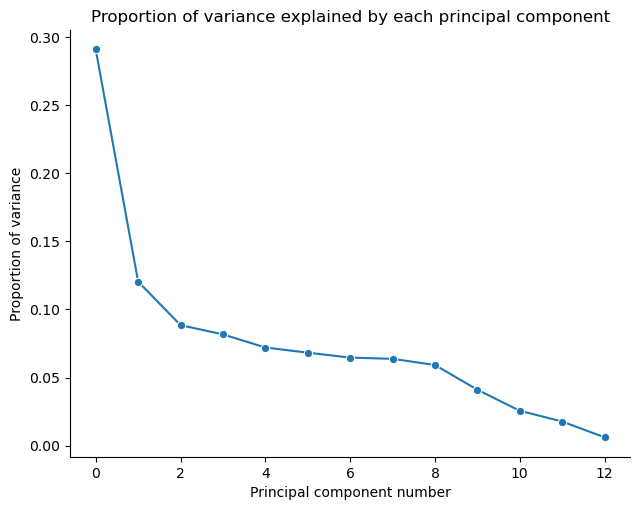

In [20]:
# def explained_variance thing
# Identifying the most informative principal components

explained_variance_array = pca.explained_variance_ratio_
explained_variance_array_df = pd.DataFrame(explained_variance_array, columns=["Variance explained"])
explained_variance_array_df["Principal component index"] = range(len(explained_variance_array))

(
# Create a line chart with sns.relplot
sns.relplot(
    kind='line',
    data=explained_variance_array_df,
    x="Principal component index",
    y="Variance explained",
    marker='o',
    aspect=1.3)
# Set the title of the plot
.set(title="Proportion of variance explained by each principal component")
# Set the axis labels
.set_axis_labels("Principal component number", "Proportion of variance")
);

#### use the elbow

In [21]:
# basic settings ----------------------> INPUT <---------------------
elbow = 5

C:\Users\Administrator\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


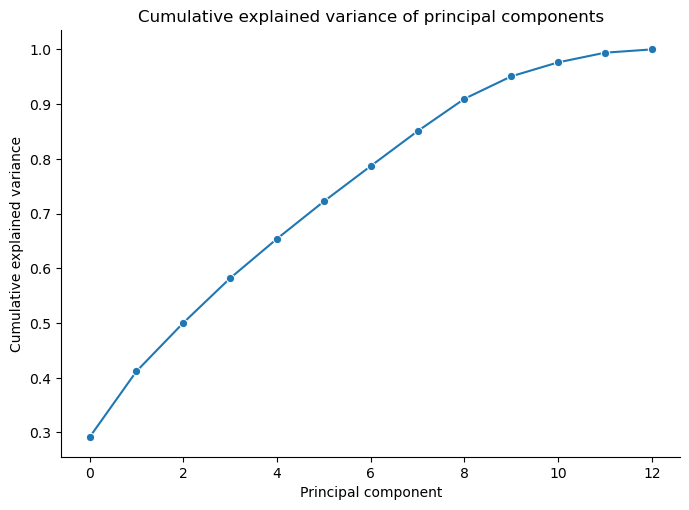

In [22]:
pca_elbow = PCA(n_components=elbow + 1)
pca_elbow_df = pca_elbow.fit_transform(df)
pca_elbow_df

# Attach cluster output to clusters_df DataFrame
my_kmeans.fit(pca_elbow_df)
clusters = my_kmeans.labels_
clusters_df[f"PCA_{elbow}"] = clusters
clusters_df.sort_values(by="base_cluster")

(
# Create a cumulative explained variance plot
sns.relplot(
    kind="line",  # Create a line plot
    x=np.arange(len(explained_variance_array)),  # Set the x-axis to be the principal component index
    y=np.cumsum(explained_variance_array),  # Set the y-axis to be the cumulative explained variance
    marker="o",  # Use a circle marker for the data points
    aspect=1.4,  # Set the aspect ratio of the plot to be 1.4
)
# Set the title of the plot
.set(title="Cumulative explained variance of principal components")
# Set the axis labels
.set_axis_labels("Principal component", "Cumulative explained variance")
);

### Cumulative Explained Variance (0.95)

C:\Users\Administrator\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


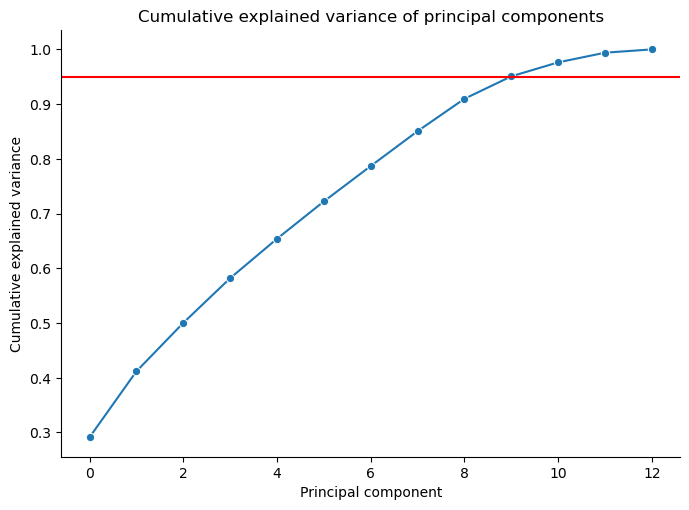

In [23]:
# Create a PCA object
pca_variance = PCA(n_components=pca_percentage)

(
# Create a cumulative explained variance plot
sns.relplot(
    kind="line",  # Create a line plot
    x=np.arange(len(explained_variance_array)),  # Set the x-axis to be the principal component index
    y=np.cumsum(explained_variance_array),  # Set the y-axis to be the cumulative explained variance
    marker="o",  # Use a circle marker for the data points
    aspect=1.4,  # Set the aspect ratio of the plot to be 1.4
)
# Set the title of the plot
.set(title="Cumulative explained variance of principal components")
# Set the axis labels
.set_axis_labels("Principal component", "Cumulative explained variance")
);

# Add a horizontal red line at 0.95 on the y axis
plt.axhline(y=0.95,
            color='red');

#### Create PCA Object

In [24]:
pca_variance_df = pca_variance.fit_transform(df)
my_kmeans.fit(pca_variance_df)
clusters = my_kmeans.labels_
clusters_df["PCA - 0.95"] = clusters
clusters_df.sort_values(by="PCA - 0.95")

,base_cluster,PCA_5,PCA - 0.95
5100,42,17,0
2453,39,25,0
1136,0,0,0
1439,47,36,1
1057,45,36,1
...,...,...,...
2457,12,36,73
4755,71,1,73
229,8,46,73
3087,44,28,74


# Modelling

## >> INPUTS <<

In [25]:
# ------------------>  Inputs  <-----------------
# Set the maximum number of clusters to be tried out
min_k = 20
max_k = 100

## Inertia and Silhouette Scores

In [26]:
def k_scores(scaled_dfs_dict):

    methods = ["minmax", "standard"]#, "robust", "quantile", "power"]
    inertia_scores_dict = {}
    sil_scores_dict = {}

    for m in methods:
        df = scaled_dfs_dict[m + "_scaled_df"]

        inertia_scores_dict["score_" + m] = []
        sil_scores_dict["score_" + m] = []

        for k in range(min_k, max_k):
            kmeans = KMeans(n_clusters=k, n_init="auto", random_state = seed)
            kmeans.fit(df)

            # INERTIA
            inertia_scores_dict["score_" + m].append(kmeans.inertia_)

            #SILHOUETTE
            labels = kmeans.labels_
            score = silhouette_score(df, labels)
            sil_scores_dict["score_" + m].append(score)

    return inertia_scores_dict, sil_scores_dict

In [27]:
# calling k_scores function
k_scores(scaled_dfs_dict)

# transform result to df (else tupel-error)
inertia_scores_dict, sil_scores_dict = k_scores(scaled_dfs_dict)
inertia_scores_df = pd.DataFrame(inertia_scores_dict)
sil_scores_df = pd.DataFrame(sil_scores_dict)

### Plotting Inertia Scores

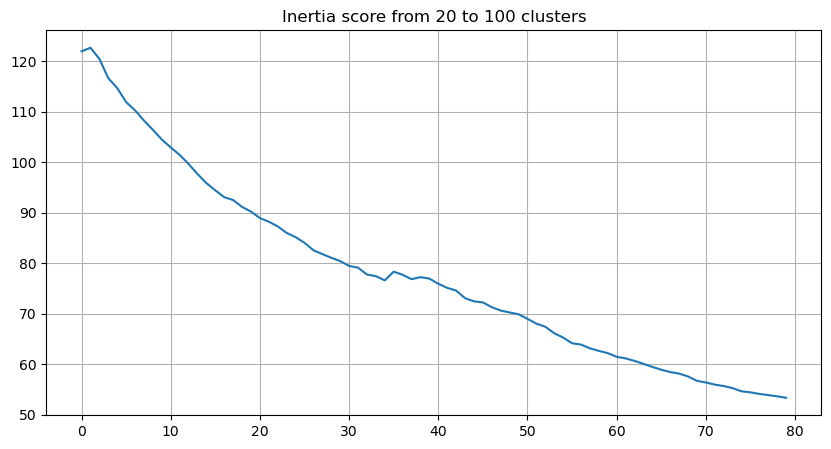

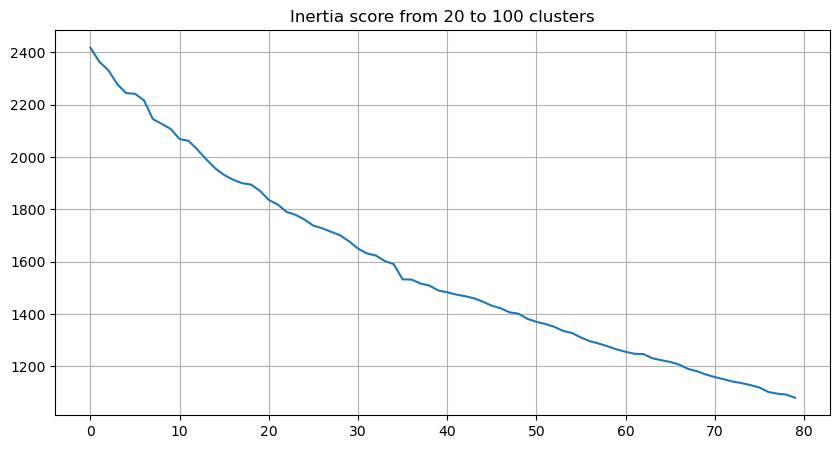

In [28]:
def inert_score_plots(inertia_scores_df):
    # keys = ["score_minmax", "score_standard", "score_robust", "score_quantile", "score_power"]

    for i in inertia_scores_df.columns:
        plt.figure(figsize=(10, 5))
        plt.plot(inertia_scores_df[i], label=i)

        plt.title(f"Inertia score from {min_k} to {max_k} clusters")
#         plt.xlabel("Number of clusters")
#         plt.ylabel("Score")
#         plt.legend()
        plt.grid(True)
        plt.show()

inert_score_plots(inertia_scores_df)

### Plotting Silhouette Scores

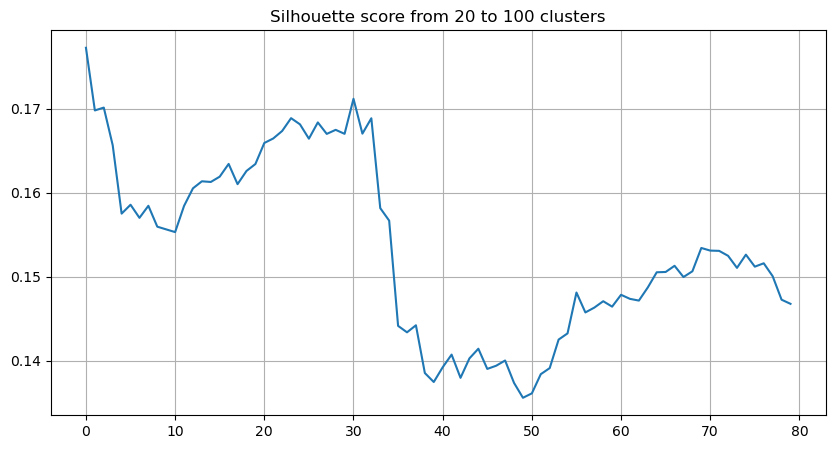

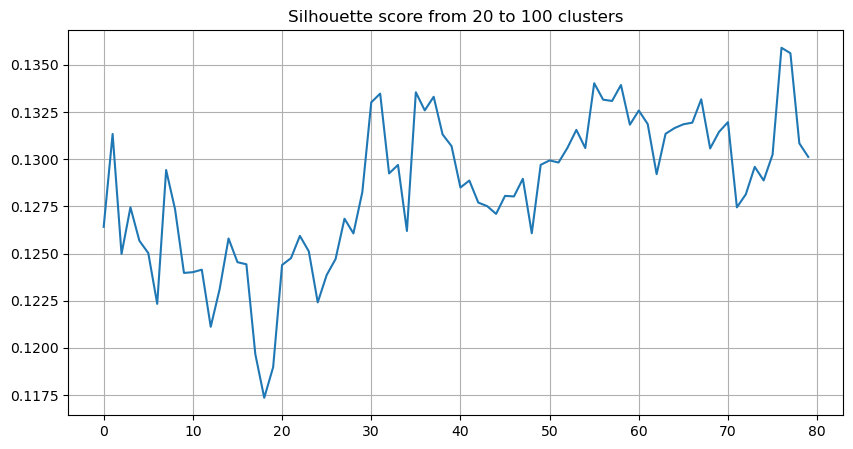

In [29]:
def silhou_score_plots(sil_scores_df):
    # keys = ["score_minmax", "score_standard", "score_robust", "score_quantile", "score_power"]

    for s in sil_scores_df.columns:
        plt.figure(figsize=(10, 5))
        plt.plot(sil_scores_df[s], label=s)

        plt.title(f"Silhouette score from {min_k} to {max_k} clusters")
#         plt.xlabel("Number of clusters")
#         plt.ylabel("Score")
#         plt.legend()
        plt.grid(True)
        plt.show()

silhou_score_plots(sil_scores_df)

## Visualisation of Centroids

In [30]:
# check centroids
centroids = kmeans.cluster_centers_
pd.DataFrame(centroids)

NameError: name 'kmeans' is not defined

In [31]:
# Calculate the euclidean distance between the centroids
centroid_distances = pairwise_distances(centroids)

NameError: name 'centroids' is not defined

### Heatmap

In [33]:
# Plot distances on heatmap
sns.heatmap(centroid_distances,
            annot=True,
            linewidths=1);

NameError: name 'centroid_distances' is not defined

### Multidimensional Plot (Radar Plot)

In [35]:
# State the label for each arm of the chart
categories = ["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"]

# Create an empty list to store the objects
trace_objects = []

# Iterate over the unique cluster numbers and add an object for each cluster to the list
for cluster in sorted(MM_scaled_df['kmeans_5cl'].unique()):
    cluster_MM_means = go.Scatterpolar(
    r=MM_scaled_df.loc[MM_scaled_df["kmeans_5cl"] == cluster].mean().tolist(),
    theta=categories,
    fill='toself',
    name=f'Cluster {cluster}'
    )
    trace_objects.append(cluster_MM_means)

# Add the objects to the figure
fig = go.Figure()
fig.add_traces(trace_objects)

# Add extras to the plot such as title
# You'll always need `polar=dict(radialaxis=dict(visible=True,range=[0, 1]))` when creating a radar plot
fig.update_layout(
  title_text = 'Radar chart of mean moosic by cluster',
  height = 600,
  width = 800,
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=True
)

# Show the initialised plot and the layers
fig.show()

NameError: name 'MM_scaled_df' is not defined

# Cluster exploration

## >> INPUTS <<

In [36]:
# min_k = 30
# max_k = 40
the_k = 76

# methods = ["minmax", "standard", "robust", "quantile", "power"]
m = "standard"

In [37]:
# data slice
scaled_df = scaled_dfs_dict[m + "_scaled_df"]

In [38]:
# create cluster51 column
kmeans = KMeans(n_clusters=the_k, n_init="auto", random_state=seed).fit(scaled_df)
scaled_df["cluster"+str(the_k)] = kmeans.predict(scaled_df)

In [39]:
scaled_df.sort_values(by="cluster76")

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster76
1136,1.079485,-0.563007,-1.453724,-0.198423,0.720942,-0.677217,-0.518282,-0.423937,0.762586,1.323056,0.186317,0.978285,0.251781,0
2453,0.437407,-0.887550,-0.053219,-0.843944,0.720942,-0.683089,-0.189533,-0.106333,-0.431363,1.803249,0.415452,1.131994,0.251781,0
5100,0.976378,-0.207719,-1.173623,-0.325810,0.720942,-0.056221,-0.882723,-0.669684,-0.636551,0.575689,0.352298,2.163316,0.251781,0
2629,0.549887,-1.222341,0.787084,-0.422539,0.720942,-0.672813,0.940369,-0.669069,-0.510006,0.196589,0.301361,3.125358,0.251781,0
280,0.854523,-0.200886,-0.333320,-0.790598,0.720942,-0.703642,-0.847031,-0.646940,-0.657999,1.431370,-0.157599,0.252524,0.251781,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4590,-1.024846,-1.389736,0.787084,-1.233771,0.720942,-0.666940,1.857551,1.932100,-0.725918,-1.275761,-0.240655,-0.300171,0.251781,75
2080,0.062470,-1.789436,1.067185,-1.048899,0.720942,-0.506920,1.849264,1.847733,-0.569346,-1.295618,0.548625,-0.151768,0.251781,75
2056,0.212445,-1.844779,0.787084,-1.377255,0.720942,-0.360113,1.846501,1.703491,-0.231180,-0.890162,-0.212083,0.480679,0.251781,75
2115,-1.104520,-1.516137,0.787084,-1.083083,0.720942,-0.358645,1.849264,1.907607,-0.374168,-1.338944,1.789967,-0.641063,0.251781,75


In [40]:
scaled_df["cluster76"].value_counts()

cluster76
14    21
3     18
57    17
54    16
22    15
      ..
16     1
63     1
73     1
32     1
31     1
Name: count, Length: 76, dtype: int64

## cluster_36 to cluster_54

In [41]:
# create dataset of specific cluster
cluster36 = scaled_df.loc[scaled_df["cluster76"] == 36]
cluster36.shape

(4, 14)

In [42]:
cluster36plus = cluster36.merge(drops, how="left", left_index=True, right_index=True)
cluster36plus[["artist", "name", "cluster76", "html"]]

,artist,name,cluster76,html
4857,Klangkarussell,Sonnentanz ...,36,https://open.spotify.com/track/7iO60TeZkNo5CZq...
4587,Autechre,Foil ...,36,https://open.spotify.com/track/07C2MiIIwVUEqcn...
2632,The Monty Alexander Trio,Monticello ...,36,https://open.spotify.com/track/0FKnknau5UBXgN2...
283,The Mountain Goats,Going to Georgia ...,36,https://open.spotify.com/track/1ey9ub4AISvEmjM...


In [43]:
cluster37 = scaled_df.loc[scaled_df["cluster76"] == 37]
cluster37plus = cluster37.merge(drops, how="left", left_index=True, right_index=True)
cluster37plus[["artist", "name", "cluster76", "html"]]

,artist,name,cluster76,html
5211,William Walton,Symphony No. 1 in B flat minor: Allegro Assai ...,37,https://open.spotify.com/track/3162cNjh7TALlf3...
5147,Ludwig van Beethoven,"Beethoven: Symphony No. 7 in A Major, Op. 92: ...",37,https://open.spotify.com/track/3UkIZn9Brm9kwri...
5187,Per Nørgård,Symphony No. 8: I. Tempo giusto - Poco allegro...,37,https://open.spotify.com/track/4UbEQasGp2JVuVb...
5229,Toru Takemitsu,A Flock Descends Into The Pentagonal Garden ...,37,https://open.spotify.com/track/0dv5IADhMkI6ZJu...
4512,William Basinski,dlp 1.3 ...,37,https://open.spotify.com/track/0DsKfyDPVSfJPWb...
5150,Pyotr Ilyich Tchaikovsky,"Symphony No. 6 in B Minor, Op. 74, TH 30 ""Path...",37,https://open.spotify.com/track/0zQx2YEcN2aGN88...
5192,Jean Sibelius,"Finlandia, Op.26 ...",37,https://open.spotify.com/track/6hrxmwz44El2T3C...


In [44]:
cluster41 = scaled_df.loc[scaled_df["cluster76"] == 41]
cluster41plus = cluster41.merge(drops, how="left", left_index=True, right_index=True)
cluster41plus[["artist", "name", "cluster76", "html"]]

,artist,name,cluster76,html
3103,Chase & Status,Blind Faith - Loadstar Remix ...,41,https://open.spotify.com/track/68u0tAIFm5VOaI8...
3591,Autopsy,Charred Remains ...,41,https://open.spotify.com/track/7ffNiXqlhPTSYyB...
931,Percy Sledge,When a Man Loves a Woman ...,41,https://open.spotify.com/track/0GVxSbigOiKlGfI...
4008,Extol,Celestial Completion ...,41,https://open.spotify.com/track/0rM0rYRTnEbi19u...


In [45]:
cluster43 = scaled_df.loc[scaled_df["cluster76"] == 43]
cluster43plus = cluster43.merge(drops, how="left", left_index=True, right_index=True)
cluster43plus[["artist", "name", "cluster76", "html"]]

,artist,name,cluster76,html
3311,Zion & Lennox,Bandida ...,43,https://open.spotify.com/track/1810h6qkazO0NWa...
4985,Rels B,A Mí ...,43,https://open.spotify.com/track/7MmrcXVA7A5zZ2C...
497,Rufus,Tell Me Something Good ...,43,https://open.spotify.com/track/0AECVMjxepWdsjD...
3310,Alexis y Fido,Soy Igual Que Tú (feat. Toby Love) ...,43,https://open.spotify.com/track/4Zil8ro7fhQGVYX...
3167,Hollie Cook,Milk & Honey ...,43,https://open.spotify.com/track/5kHSFEtrXMjXnqS...
642,Jason Derulo,Trumpets ...,43,https://open.spotify.com/track/6jizk5lOUnfpaZX...
2310,Fugees,Fu-Gee-La ...,43,https://open.spotify.com/track/1rJM37Dd4OcSJvz...


In [46]:
cluster46 = scaled_df.loc[scaled_df["cluster76"] == 46]
cluster46plus = cluster46.merge(drops, how="left", left_index=True, right_index=True)
cluster46plus[["artist", "name", "cluster76", "html"]]

,artist,name,cluster76,html
5202,Elliott Carter,Symphonia: Sum Fluxae Pretium Spei: 2. Adagio ...,46,https://open.spotify.com/track/46SNnjsI9XWJyz3...
2571,John Coltrane,My Favorite Things ...,46,https://open.spotify.com/track/2JOEPbuwVf0nafG...


In [47]:
cluster48 = scaled_df.loc[scaled_df["cluster76"] == 48]
cluster48plus = cluster48.merge(drops, how="left", left_index=True, right_index=True)
cluster48plus[["artist", "name", "cluster76", "html"]]

,artist,name,cluster76,html
3603,Bolt Thrower,Cenotaph ...,48,https://open.spotify.com/track/59mAOFlD6Qg0ygG...
3843,Convulse,World Without God ...,48,https://open.spotify.com/track/5BfxgYOt5MLCRK4...
3796,Vader,Final Massacre ...,48,https://open.spotify.com/track/5YcjcQqhrsMNwja...
4500,Cryptopsy,Mutant Christ ...,48,https://open.spotify.com/track/0RspwvCRbt6Ce6L...
3933,Bolt Thrower,Embers ...,48,https://open.spotify.com/track/7gI0o0dUMA0RSo2...
3633,Bloodbath,So You Die ...,48,https://open.spotify.com/track/48JUQCIgAO8lI8n...
4473,Bolt Thrower,Through the Eye of Terror ...,48,https://open.spotify.com/track/1j61N2oXIo7y5eU...
4276,Desecrator,Killing Joke ...,48,https://open.spotify.com/track/6vsyhViXwyLpWpO...


In [48]:
cluster49 = scaled_df.loc[scaled_df["cluster76"] == 49]
cluster49plus = cluster49.merge(drops, how="left", left_index=True, right_index=True)
cluster49plus[["artist", "name", "cluster76", "html"]]

,artist,name,cluster76,html
2978,Dimitri Vegas & Like Mike,Higher Place - Tujamo Remix ...,49,https://open.spotify.com/track/0bnQsGWNl2LLU2U...
1659,Keri Hilson,Knock You Down ...,49,https://open.spotify.com/track/3OWcWJz1c0pIc6L...
2721,Skrillex,Bangarang (feat. Sirah) ...,49,https://open.spotify.com/track/6VRhkROS2SZHGlp...
2841,Zedd,Dovregubben ...,49,https://open.spotify.com/track/1dvvM2Hk43hGKEA...
4987,Ozuna,El Farsante ...,49,https://open.spotify.com/track/5EId1m4DNwTf3at...
460,Os Mutantes,A Minha Menina ...,49,https://open.spotify.com/track/3CCGsOj2efotChi...
2836,David Guetta,Clap Your Hands ...,49,https://open.spotify.com/track/4Rc4eaDQIXwEsef...
658,Sean Paul,No Lie ...,49,https://open.spotify.com/track/2ZiDfw6UdzDu754...
4831,Unheilig,Winter - Single Version ...,49,https://open.spotify.com/track/3iCtenuKDf5hFnL...


In [49]:
cluster50 = scaled_df.loc[scaled_df["cluster76"] == 50]
cluster50plus = cluster36.merge(drops, how="left", left_index=True, right_index=True)
cluster50plus[["artist", "name", "cluster76", "html"]]

,artist,name,cluster76,html
4857,Klangkarussell,Sonnentanz ...,36,https://open.spotify.com/track/7iO60TeZkNo5CZq...
4587,Autechre,Foil ...,36,https://open.spotify.com/track/07C2MiIIwVUEqcn...
2632,The Monty Alexander Trio,Monticello ...,36,https://open.spotify.com/track/0FKnknau5UBXgN2...
283,The Mountain Goats,Going to Georgia ...,36,https://open.spotify.com/track/1ey9ub4AISvEmjM...


In [50]:
cluster51 = scaled_df.loc[scaled_df["cluster76"] == 51]
cluster51plus = cluster51.merge(drops, how="left", left_index=True, right_index=True)
cluster51plus[["artist", "name", "cluster76", "html"]]

,artist,name,cluster76,html
235,Vic Chesnutt,Assist ...,51,https://open.spotify.com/track/1K8QDzkFc5WgGZs...
5153,Carl Philipp Emanuel Bach,"Symphony No. 1 in D major, Wq. 183/1: Symphony...",51,https://open.spotify.com/track/7125Z776uNesKF0...
2406,Umberto Giordano,"Giordano: Andrea Chénier, Act 3: ""La mamma mor...",51,https://open.spotify.com/track/36soyVMvHB2FRb0...
2612,Lou Donaldson,Over The Rainbow ...,51,https://open.spotify.com/track/08lUeu1CxXvAoaK...
2400,Charles Gounod,"Roméo et Juliette, CG 9 / Act 1: ""Ah, je veux ...",51,https://open.spotify.com/track/3GW78c0NinQpL8H...


In [51]:
cluster53 = scaled_df.loc[scaled_df["cluster76"] == 53]
cluster53plus = cluster53.merge(drops, how="left", left_index=True, right_index=True)
cluster53plus[["artist", "name", "cluster76", "html"]]

,artist,name,cluster76,html
4398,Wombbath,Conceal Interior Torments ...,53,https://open.spotify.com/track/6t3DGbF56mJ7Cx5...
3757,Edge Of Sanity,"Crimson, Pt. 2 ...",53,https://open.spotify.com/track/2OUw7fuHCxFy2h7...
3673,Carnage,Dark Recollections ...,53,https://open.spotify.com/track/72klAZkuIGe7tdK...
4483,Monstrosity,Manic ...,53,https://open.spotify.com/track/6Y41eEZ7w6FzOyF...
3391,Obituary,Redneck Stomp ...,53,https://open.spotify.com/track/2fSYadDsbWMtIVq...
3701,Napalm Death,Unfit Earth ...,53,https://open.spotify.com/track/6TcTjkptOtIF6sX...
4375,Funebre,Congenital Defeat ...,53,https://open.spotify.com/track/1kIPKmmfZDxW1XQ...
3926,Monstrosity,Devious Instinct ...,53,https://open.spotify.com/track/15dDRmeAt5oA9VK...
4325,Broken Hope,Dilation And Extraction ...,53,https://open.spotify.com/track/7vyXDVRAtcT6G4F...
3464,Darkthrone,Cromlech - Studio ...,53,https://open.spotify.com/track/7bTxVZKtDkOX95Q...


## cluster_19 to cluster_34

In [52]:
cluster19 = scaled_df.loc[scaled_df["cluster76"] == 19]
cluster19plus = cluster19.merge(drops, how="left", left_index=True, right_index=True)
cluster19plus[["artist", "name", "cluster76", "html"]]

,artist,name,cluster76,html
4931,CRO,Unendlichkeit ...,19,https://open.spotify.com/track/5caMCe2gq8y72GV...
108,Gal Costa,Coração Vagabundo ...,19,https://open.spotify.com/track/1yhuvsoxqYNw7gD...


In [53]:
cluster21 = scaled_df.loc[scaled_df["cluster76"] == 21]
cluster21plus = cluster21.merge(drops, how="left", left_index=True, right_index=True)
cluster21plus[["artist", "name", "cluster76", "html"]]

,artist,name,cluster76,html
2901,Bingo Players,Rattle ...,21,https://open.spotify.com/track/3uXzBSx2eMKRTEP...
467,Parquet Courts,Pretty Machines ...,21,https://open.spotify.com/track/1zPn4tfkWfowVG3...
2750,Afrojack,Turn Up The Speakers - Original Mix ...,21,https://open.spotify.com/track/1Sj5poNJIwQv1Rv...
3097,DJ Zinc,Casino Royale ...,21,https://open.spotify.com/track/7dWYzVDxFBbUrvA...
2964,Alok,Fuego ...,21,https://open.spotify.com/track/30pVSKdzBpZ9Np4...
2902,Swedish House Mafia,Greyhound ...,21,https://open.spotify.com/track/0VffaI2jwQknRrx...
3088,Renegade,Terrorist - P.A. Mix ...,21,https://open.spotify.com/track/11ZQDGsvYVBHPGp...


In [54]:
cluster22 = scaled_df.loc[scaled_df["cluster76"] == 22]
cluster22plus = cluster22.merge(drops, how="left", left_index=True, right_index=True)
cluster22plus[["artist", "name", "cluster76", "html"]]

,artist,name,cluster76,html
4843,Philipp Poisel,Eiserner Steg ...,22,https://open.spotify.com/track/0Fn9CmTw6nIYExe...
344,The Lovin' Spoonful,Do You Believe in Magic? ...,22,https://open.spotify.com/track/1udKn1oNKYQSQ9O...
1252,Lionel Richie,Dancing On The Ceiling ...,22,https://open.spotify.com/track/0snPJPxkk0MbTc0...
4828,Juli,Elektrisches Gefühl ...,22,https://open.spotify.com/track/3mtTc2I7SACbvia...
294,Mac DeMarco,The Stars Keep On Calling My Name ...,22,https://open.spotify.com/track/1LnUkEqDPybqqvc...
3521,Unleashed,To Asgard We Fly ...,22,https://open.spotify.com/track/5tP4IaWawcaU05q...
2954,Baauer,Harlem Shake ...,22,https://open.spotify.com/track/01XFgRZfZI7oBag...
4648,Stray Kids,God’s Menu ...,22,https://open.spotify.com/track/0RzT9tBLcQhofW2...
532,Kid Francescoli,"It's Only Music, Baby ...",22,https://open.spotify.com/track/1YJkEWW96uWVf7G...
4817,Höhner,Schenk mir dein Herz - Radio Edit ...,22,https://open.spotify.com/track/4slvkuyNSkOg8M8...


In [55]:
cluster25 = scaled_df.loc[scaled_df["cluster76"] == 25]
cluster25plus = cluster25.merge(drops, how="left", left_index=True, right_index=True)
cluster25plus[["artist", "name", "cluster76", "html"]]

,artist,name,cluster76,html
35,Bïa,Mariana ...,25,https://open.spotify.com/track/4Lx7fiZRVb7j4U1...
723,Ed Sheeran,Sing ...,25,https://open.spotify.com/track/6K8qKeWo5MsFED7...
75,Various Artists,Lisboa menina e moça ...,25,https://open.spotify.com/track/1ygyaDfAly6uDoR...
5085,Jonathan Traylor,High Up ...,25,https://open.spotify.com/track/0drumuKkSeMz3CH...
1669,Rihanna,Hate That I Love You ...,25,https://open.spotify.com/track/7iu0WYLdo4yksKf...
1775,Justin Bieber,What Do You Mean? ...,25,https://open.spotify.com/track/4B0JvthVoAAuygI...
2312,Diddy,Been Around the World (feat. The Notorious B.I...,25,https://open.spotify.com/track/0xsbBYgKasUkHM0...
702,Martin Jensen,Nobody ...,25,https://open.spotify.com/track/2qfEcCkEo5NscA9...
73,Manu Chao,Homens ...,25,https://open.spotify.com/track/19SaQ50zJG69AUr...
2589,Horace Silver,Song For My Father ...,25,https://open.spotify.com/track/1CDBaGlisZlOJzv...


In [56]:
cluster26 = scaled_df.loc[scaled_df["cluster76"] == 26]
cluster26plus = cluster26.merge(drops, how="left", left_index=True, right_index=True)
cluster26plus[["artist", "name", "cluster76", "html"]]

,artist,name,cluster76,html
4412,Brutality,Shrine of the Master ...,26,https://open.spotify.com/track/3CnodhcirIpgohe...
4374,Funebre,Shiver ...,26,https://open.spotify.com/track/2ZnoeViImBYIQKu...
2737,Showtek,We Like To Party ...,26,https://open.spotify.com/track/53ROeduQXgL4Uge...
3483,Cannibal Corpse,The Bleeding ...,26,https://open.spotify.com/track/17X3hKnGxGle8QR...
3576,Bolt Thrower,"No Guts, No Glory ...",26,https://open.spotify.com/track/5tUxhJPbbOB4vEw...
4113,Darkthrone,Soulside Journey - Studio ...,26,https://open.spotify.com/track/702PchwBVAoVST4...
3622,Necrophagia,Bleeding Torment ...,26,https://open.spotify.com/track/2puMdQfKbBb7Hgb...


In [57]:
cluster28 = scaled_df.loc[scaled_df["cluster76"] == 28]
cluster28plus = cluster28.merge(drops, how="left", left_index=True, right_index=True)
cluster28plus[["artist", "name", "cluster76", "html"]]

,artist,name,cluster76,html
244,L.A.,Dualize ...,28,https://open.spotify.com/track/2PIC7KxAgHGYCGu...
4204,MACABRE,Hitchhiker ...,28,https://open.spotify.com/track/1sfAvEhjwftgdHN...
1152,Chicago,If You Leave Me Now ...,28,https://open.spotify.com/track/0KMGxYKeUzK9wc5...
1392,Hanson,MMMBop ...,28,https://open.spotify.com/track/0lnxrQAd9ZxbhBB...
626,Ellie Goulding,Sixteen ...,28,https://open.spotify.com/track/4PkIDTPGedm0enz...
2329,Volbeat,A Warrior's Call ...,28,https://open.spotify.com/track/5mNbJIYaKkphf5W...
1632,The Script,Breakeven ...,28,https://open.spotify.com/track/4bCIt1XfHHGWo1U...
4937,Wincent Weiss,An Wunder ...,28,https://open.spotify.com/track/1I2ziAYoM5rEh5u...
2699,Krewella,Alive - Radio Edit ...,28,https://open.spotify.com/track/7bpeW7tk744p4W5...
1726,Zedd,The Middle ...,28,https://open.spotify.com/track/09IStsImFySgyp0...


In [58]:
cluster29 = scaled_df.loc[scaled_df["cluster76"] == 29]
cluster29plus = cluster29.merge(drops, how="left", left_index=True, right_index=True)
cluster29plus[["artist", "name", "cluster76", "html"]]

,artist,name,cluster76,html
2889,Kaskade,Lessons In Love - Headhunterz Remix Radio Edit...,29,https://open.spotify.com/track/0OiB8C5GNSBuyyZ...
4066,Obituary,World Demise ...,29,https://open.spotify.com/track/4jrsh8f6iDT4klU...
3862,Morbid Angel,Suffocation ...,29,https://open.spotify.com/track/4FEVlellEnS57ns...
3856,Merciless,Pure Hate ...,29,https://open.spotify.com/track/33KDF9AR79PlZtL...
3491,Deicide,Trifixion ...,29,https://open.spotify.com/track/7ryTlGZ8Edd2XQI...
2986,Chocolate Puma,Step Back - Radio Edit ...,29,https://open.spotify.com/track/2fBrA1nneKAnAnV...
1337,The Pointer Sisters,I'm So Excited ...,29,https://open.spotify.com/track/1ot6jEe4w4hYnsO...
3382,Obituary,Chopped in Half ...,29,https://open.spotify.com/track/01cGujYWGF7JchJ...
2782,Sander van Doorn,Lost ...,29,https://open.spotify.com/track/5WeL7ruThFERubI...
4664,U96,Das Boot ...,29,https://open.spotify.com/track/6hkdMs3DqEdG0rI...


In [59]:
cluster30 = scaled_df.loc[scaled_df["cluster76"] == 30]
cluster30plus = cluster30.merge(drops, how="left", left_index=True, right_index=True)
cluster30plus[["artist", "name", "cluster76", "html"]]

,artist,name,cluster76,html
872,Ritchie Valens,La Bamba - Single Version ...,30,https://open.spotify.com/track/2aEeghgUcnu75tz...
1762,Meghan Trainor,Dear Future Husband ...,30,https://open.spotify.com/track/7n9yUpEJ040pu49...
4862,Sido,Bilder im Kopf ...,30,https://open.spotify.com/track/3AzVdNe7tCYbjjR...


In [60]:
cluster31 = scaled_df.loc[scaled_df["cluster76"] == 31]
cluster31plus = cluster31.merge(drops, how="left", left_index=True, right_index=True)
cluster31plus[["artist", "name", "cluster76", "html"]]

,artist,name,cluster76,html
1104,Peter Gabriel,Solsbury Hill ...,31,https://open.spotify.com/track/6vZZtivPrtpggT5...


In [61]:
cluster31 = scaled_df.loc[scaled_df["cluster76"] == 30]
cluster31plus = cluster31.merge(drops, how="left", left_index=True, right_index=True)
cluster31plus[["artist", "name", "cluster76", "html"]]

,artist,name,cluster76,html
872,Ritchie Valens,La Bamba - Single Version ...,30,https://open.spotify.com/track/2aEeghgUcnu75tz...
1762,Meghan Trainor,Dear Future Husband ...,30,https://open.spotify.com/track/7n9yUpEJ040pu49...
4862,Sido,Bilder im Kopf ...,30,https://open.spotify.com/track/3AzVdNe7tCYbjjR...


In [62]:
cluster22.to_csv('data/song_cluster22_KKo.csv')